In [1]:
"""
PointNet Implementation for Point Cloud Classification using PyTorch
"""

'\nPointNet Implementation for Point Cloud Classification using PyTorch\n'

In [2]:
# import necessary dependencies
import numpy as np
import math
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from path import Path

In [3]:
random.seed = 42

In [4]:
# download dataset - ModelNet10
""""
    ModelNet10 consists of objects from 10 categories
    3,991 models for training and 908 for testing
"""
path = Path("./dataset/ModelNet10/ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)}
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [5]:
# function to read the .off files
"""
    This dataset consists of .off files that contain meshes represented by vertices and triangular faces
"""
def read_off(file):
    
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)] # vertices
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)] # triangular faces
    
    return verts, faces

In [6]:
# a test on read_off() function
with open(path/"bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)

x, y, z = np.array(verts).T # x -> verts.x, y -> verts.y, z -> verts.z
i, j, k = np.array(faces).T # i -> faces.x, j -> faces.y, k -> faces.z

print(">>> number of vertices: " + str(len(verts)))
print(">>> number of triangular faces: " + str(len(faces)))

>>> number of vertices: 2095
>>> number of triangular faces: 1807


In [7]:
# generate animated rotation of meshes and point clouds
def visualize_rotate(data):
    
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x + 1j * y
        return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))

    # import plotly.graph_objects as go
    fig = go.Figure(data=data,
                    layout=go.Layout(updatemenus=[dict(type='buttons',
                                                  showactive=False,
                                                  y=1,
                                                  x=0.8,
                                                  xanchor='left',
                                                  yanchor='bottom',
                                                  pad=dict(t=45, r=10),
                                                  buttons=[dict(label='Play',
                                                                method='animate',
                                                                args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                                 transition=dict(duration=0),
                                                                                 fromcurrent=True,
                                                                                 mode='immediate'
                                                                                )
                                                                     ]
                                                               )
                                                          ]
                                                      )
                                                 ]
                                    ),
                    frames=frames
                   )

    return fig

In [8]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i, j=j, k=k)]).show()

In [9]:
# visualize point clouds to see vertices better
def visualize_point_cloud(xs, ys, zs):
    
    data = [go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [10]:
visualize_point_cloud(x, y, z)
""""
    Actually, flat parts of a surface do not require any points for mesh construction. 
    That is why points are primarily located at angles and rounded parts of the 3D model.
"""

'"\n    Actually, flat parts of a surface do not require any points for mesh construction. \n    That is why points are primarily located at angles and rounded parts of the 3D model.\n'

In [11]:
# sample points
class PointSampler(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    # calculate the size of a triangle area
    """
       def triangle_area(a, b, c):
           s = (a + b + c) / 2
           # Area using Heron's formula
           area = math.sqrt(s * (s - a) * (s - b) * (s - c))
           return area 
    """
    def triangle_area(self, pt1, pt2, pt3):
        # compute the length of each side
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = ( side_a + side_b + side_c) / 2
        area = math.sqrt(max(s * (s - side_a) * (s - side_b) * (s - side_c), 0))
        return area
    
    def sample_point(self, pt1, pt2, pt3):
        # using barycentric coordinates on a triangle
        """
            for a triangle with vertices A, B, and C, any point P inside the triangle can be represented as:
                    P = λ_1 * A + λ_2 * B + λ_3 * C
            while λ_1, λ_2, and λ_3 are the barycentric coordinates of the point P 
            with respect to the triangle vertices A, B, and C, and λ_1 + λ_2 + λ_3 =1
        """
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
        return (f(0), f(1), f(2)) # return one sample point on the triangle (pt1, pt2, pt3)

    # enable instances of the class to be invoked as functions
    """
        for example: point_cloud = PointSampler(3000)(_mesh)
    """
    def __call__(self, mesh):
        verts, faces = mesh # faces.x, faces.y, and faces.z are the indice of verts
        verts = np.array(verts)
        areas = np.zeros(len(faces))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]])) # verts[faces[i][0]] -> pt1, verts[faces[i][1]] -> pt2, verts[faces[i][2]] -> pt3
        
        sampled_faces = (random.choices(faces,
                                        weights=areas,
                                        cum_weights=None,
                                        k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [12]:
pointcloud = PointSampler(1024)((verts, faces)) # pointcloud -> (output_size, 3), point_cloud.T -> (3, output_size)
visualize_point_cloud(*pointcloud.T)

In [13]:
# data augmentations
# normalization
"""
    translate the object to the origin by subtracting mean from all its points and normalize its points into a unit sphere
"""
class Normalize(object):
    
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1)) # norm_pointcloud -> (output_size, 3)

        return norm_pointcloud

In [14]:
norm_pointcloud = Normalize()(pointcloud)
visualize_point_cloud(*norm_pointcloud.T)

In [15]:
# random rotation around z-axis
class RandomRotation_z(object):
    
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        theta = random.random() * 2. * math.pi # rotation angle
        rotation_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                                    [ math.sin(theta),  math.cos(theta),    0],
                                    [               0,                0,    1]]) # rotation_matrix -> (3, 3)
        rotated_pointcloud = rotation_matrix.dot(pointcloud.T).T # rotated_pointcloud -> (output_size, 3)

        return rotated_pointcloud

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

rotated_pointcloud = RandomRotation_z()(norm_pointcloud)
visualize_point_cloud(*rotated_pointcloud.T)

In [17]:
# add gaussian noise
class RandomNoise(object):
    
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        noise = np.random.normal(0, 0.05, (pointcloud.shape)) # mean = 0, standard deviation = 0.02
        noisy_pointcloud = pointcloud + noise # noisy_pointcloud -> (output_size, 3)

        return noisy_pointcloud

In [18]:
noisy_pointcloud = RandomNoise()(rotated_pointcloud)
visualize_point_cloud(*noisy_pointcloud.T)

In [19]:
# to tensor
class ToTensor(object):
    
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        return torch.from_numpy(pointcloud)

In [20]:
ToTensor()(noisy_pointcloud)

tensor([[ 0.5065, -0.0054, -0.1429],
        [-0.2348, -0.4015,  0.0057],
        [ 0.4132, -0.5363,  0.2799],
        ...,
        [ 0.1024, -0.4838,  0.0252],
        [-0.3667,  0.6514,  0.0738],
        [ 0.5077,  0.6937,  0.1342]], dtype=torch.float64)

In [21]:
# default transforms
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [22]:
# dataset
class PointCloudData(Dataset):
    
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []

        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):

        return len(self.files)
    
    def __preproc__(self, file): # preprocessing
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))

        return pointcloud
    
    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)

        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [23]:
# training transforms
train_transforms = transforms.Compose([
                                        PointSampler(1024),
                                        Normalize(),
                                        RandomRotation_z(),
                                        RandomNoise(),
                                        ToTensor()
                                     ]) # input should be pointcloud or (verts, faces)

In [24]:
# create train dataset and test dataset
train_dataset = PointCloudData(path, transform=train_transforms)
valid_dataset = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [25]:
inv_classes = {i: cat for cat, i in train_dataset.classes.items()}
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [26]:
print('>>> Train dataset size: ', len(train_dataset))
print('>>> Valid dataset size: ', len(valid_dataset))
print('>>> Number of classes: ', len(train_dataset.classes))
print('>>> Sample pointcloud shape: ', train_dataset[0]['pointcloud'].size())
print('>>> Class: ', inv_classes[train_dataset[0]['category']])

>>> Train dataset size:  3991
>>> Valid dataset size:  908
>>> Number of classes:  10
>>> Sample pointcloud shape:  torch.Size([1024, 3])
>>> Class:  bathtub


In [27]:
# create dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64)

print('>>> Train loader size: ', len(train_loader))
print('>>> Valid loader size: ', len(valid_loader))

>>> Train loader size:  125
>>> Valid loader size:  15


In [28]:
# tnet
class Tnet(nn.Module):
    """
        The output of the Tnet is the input transform or feature transform, the shape of whichis (batch_size, k, k)
        k = 3 if input transform 
        k = 64 if feature transform
    """

    def __init__(self, k=3): # k = 3 if input transform or k = 64 if feature transform
        super().__init__()

        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input): # input.shape -> (batch_size, k, num_point)

        batch_size = input.size(0)
        num_point = input.size(-1)

        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = F.relu(self.bn3(self.conv3(output))) # output.shape -> (batch_size, 1024, num_point)

        output = nn.MaxPool1d(num_point)(output) # output.shape -> (batch_size, 1024, 1)
        output = nn.Flatten(1)(output) # output.shape -> (batch_size, 1024)

        output = F.relu(self.bn4(self.fc1(output)))
        output = F.relu(self.bn5(self.fc2(output))) 
        output = self.fc3(output) # output.shape -> (batch_size, k*k)

        output = output.view(-1, self.k, self.k) # output.shape -> (batch_size, k, k)
        I = torch.eye(self.k, requires_grad=True).repeat(batch_size, 1, 1) # I.shape -> (batch_size, k, k)
        if output.is_cuda:
            I = I.cuda()
        output = output + I

        return output # output.shape -> (batch_size, k, k)

In [29]:
# test
tnet = Tnet()
input = torch.randn(6, 1024, 3) # batch_size=6, num_point=1024, channels=3
input = input.transpose(1, 2)
output = tnet(input)

print('>>> Tnet input size: ', input.size())
print('>>> Tnet output size: ', output.size())

>>> Tnet input size:  torch.Size([6, 3, 1024])
>>> Tnet output size:  torch.Size([6, 3, 3])


In [30]:
# transform
class TransformNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)

        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input): # input.shape -> (batch_size, 3, num_point)

        batch_size = input.size(0)
        num_point = input.size(-1)

        matrix_3x3 = self.input_transform(input) # matrix_3x3 -> (batch_size, 3, 3)
        output = torch.bmm(torch.transpose(input, 1, 2), matrix_3x3).transpose(2, 1) # output -> (batch_size, 3, num_point)

        output = F.relu(self.bn1(self.conv1(output))) # output -> (batch_size, 64, num_point)

        matrix_64x64 = self.feature_transform(output) # matrix_64x64 -> (batch_size, 64, 64)
        output = torch.bmm(torch.transpose(output, 1, 2), matrix_64x64).transpose(2, 1) # output -> (batch_size, 64, num_point)

        output = F.relu(self.bn2(self.conv2(output))) # output -> (batch_size, 128, num_point)
        output = self.bn3(self.conv3(output)) # output -> (batch_size, 1024, num_point)

        output = nn.MaxPool1d(num_point)(output) # output -> (batch_size, 1024, 1)
        output = nn.Flatten(1)(output) # output -> (batch_size, 1024)

        return output, matrix_3x3, matrix_64x64
        """
                  output -> (batch_size, 1024)
              matrix_3x3 -> (batch_size, 3, 3)
            matrix_64x64 -> (batch_size, 64, 64)
        """

In [31]:
# test
transform = TransformNet()
input = torch.randn(6, 1024, 3) # batch_size=6, num_point=1024, channels=3
input = input.transpose(1, 2)
output, matrix_3x3, matrix_64x64 = transform(input)

print('>>> TransformNet input size: ', input.size())
print('>>> TransformNet output size: ', output.size())
print('>>> Matrix_3x3 size: ', matrix_3x3.size())
print('>>> Matrix_64x64 size: ', matrix_64x64.size())

>>> TransformNet input size:  torch.Size([6, 3, 1024])
>>> TransformNet output size:  torch.Size([6, 1024])
>>> Matrix_3x3 size:  torch.Size([6, 3, 3])
>>> Matrix_64x64 size:  torch.Size([6, 64, 64])


In [32]:
# pointnet
class PointNet(nn.Module):

    def __init__(self, classes=10):
        super().__init__()

        self.transform = TransformNet() 
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3) # for the last mlp in classification net
        self.logsoftmax = nn.LogSoftmax(dim=1) # for classification, output -> (batch_size, classes)

    def forward(self, input): # input.shape -> (batch_size, 3, num_point)
        
        output, matrix_3x3, matrix_64x64 = self.transform(input) # output -> (batch_size, 1024)
        output = F.relu(self.bn1(self.fc1(output))) # output -> (batch_size, 512)
        output = F.relu(self.bn2(self.dropout(self.fc2(output)))) # output -> (batch_size, 256)
        output = self.fc3(output) # output -> (batch_size, classes)
        output = self.logsoftmax(output) # output -> (batch_size, classes)

        return output, matrix_3x3, matrix_64x64
        """
                  output -> (batch_size, classes=10)
              matrix_3x3 -> (batch_size, 3, 3)
            matrix_64x64 -> (batch_size, 64, 64)
        """

In [33]:
# test
pointnet = PointNet()
input = torch.randn(6, 1024, 3) # batch_size=6, num_point=1024, channels=3
input = input.transpose(1, 2)
output, matrix_3x3, matrix_64x64 = pointnet(input)

print('>>> PointNet input size: ', input.size())
print('>>> PointNet output size: ', output.size())
print('>>> Matrix_3x3 size: ', matrix_3x3.size())
print('>>> Matrix_64x64 size: ', matrix_64x64.size())

>>> PointNet input size:  torch.Size([6, 3, 1024])
>>> PointNet output size:  torch.Size([6, 10])
>>> Matrix_3x3 size:  torch.Size([6, 3, 3])
>>> Matrix_64x64 size:  torch.Size([6, 64, 64])


In [34]:
# loss
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):

    """
             outputs -> (batch_size, classes=10)
              labels -> (batch_size, )
                m3x3 -> (batch_size, 3, 3)
              m64x64 -> (batch_size, 64, 64)
               alpha -> regularization weight
    """
    
    criterion = torch.nn.NLLLoss() # use Negative Log-Likelihood Loss for multi-class classification
    batch_size = outputs.size(0) # pointnet outputs -> (batch_size, classes)

    I3x3 = torch.eye(3, requires_grad=True).repeat(batch_size, 1, 1)
    I64x64 = torch.eye(64, requires_grad=True).repeat(batch_size, 1, 1)

    if outputs.is_cuda:
        I3x3 = I3x3.cuda()
        I64x64 = I64x64.cuda()

    # regularization terms
    Lreg_3x3 = torch.norm(I3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2)))
    Lreg_64x64 = torch.norm(I64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2)))

    # add regularization terms to the training loss
    loss = criterion(outputs, labels) + alpha * (Lreg_3x3 + Lreg_64x64) / float(batch_size)

    return loss

In [35]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# network
pointnet = PointNet()
pointnet.to(device)

# optimizer
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001) 

In [36]:
# training loop
def train(model, train_loader, valid_loader=None, epochs=20, save=False):

    training_loss = []
    batch_loss = []
    validation_accuracy = []

    print('>>> ----------- Training loop is starting -----------')

    for epoch in range(epochs):
        
        # training
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader):
            """
                      data -> {'pointcloud': pointcloud, 'category': self.classes[category]}
                pointcloud -> (batch_size=32, num_point=1024, 3)
                  category -> (batch_size, )
            """
            inputs = data['pointcloud'].to(device).float()
            labels = data['category'].to(device)

            # send inputs to the model
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))

            # calculate loss
            loss = pointnetloss(outputs, labels, m3x3, m64x64)    

            # optimizer update
            optimizer.zero_grad() # zero the gradients
            loss.backward() # backpropagation
            optimizer.step() # update weights

            # print statistics info
            running_loss += loss

            if (i+1) % 25 == 0: # print statistics info every 25 batches

                print('>>> Epoch: %d, Batch: %3d / %3d, loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 25))
                batch_loss.append(running_loss / 25)
                running_loss = 0.0

        epoch_time = time.time() - start_time  # calculate time taken for the epoch
        print('>>> Epoch %d training time: %.3f seconds' % (epoch + 1, epoch_time))

        epoch_loss = sum(batch_loss) / len(batch_loss)
        epoch_loss = epoch_loss.cpu().item()
        training_loss.append(epoch_loss)
        batch_loss = []

        # validation
        model.eval()
        correct = total = 0

        if valid_loader:
            with torch.no_grad():
                for data in valid_loader:

                    inputs = data['pointcloud'].to(device).float()
                    labels = data['category'].to(device)

                    outputs, _, _ = model(inputs.transpose(1, 2)) # outputs -> (batch_size, classes)
                    _, predicts = torch.max(outputs.data, 1)

                    total += labels.size(0)
                    correct += (predicts == labels).sum().item()

            valid_accuracy = 100. * correct / total
            validation_accuracy.append(valid_accuracy)
            print('>>> Validation accuracy: %d%%' % valid_accuracy)

            if (epoch + 1) != epochs:
                print('>>> -------------------------------------------------')                 

        # save the model
        if save:
            torch.save(model.state_dict(), "save_" + str(epoch) + ".pth")

    print('>>> ----------- Training loop is finished -----------')

    return training_loss, validation_accuracy

In [353]:
# train the network
training_loss, validation_accuracy = train(pointnet, train_loader, valid_loader, save=False)

print('>>> Training loss: ', training_loss)
print('>>> Validation accuracy: ', validation_accuracy)

>>> ----------- Training loop is starting -----------
>>> Epoch: 1, Batch:  25 / 125, loss: 1.740
>>> Epoch: 1, Batch:  50 / 125, loss: 1.223
>>> Epoch: 1, Batch:  75 / 125, loss: 1.086
>>> Epoch: 1, Batch: 100 / 125, loss: 1.066
>>> Epoch: 1, Batch: 125 / 125, loss: 1.004
>>> Epoch 1 training time: 552.334 seconds
>>> Validation accuracy: 64%
>>> -------------------------------------------------
>>> Epoch: 2, Batch:  25 / 125, loss: 0.833
>>> Epoch: 2, Batch:  50 / 125, loss: 0.816
>>> Epoch: 2, Batch:  75 / 125, loss: 0.790
>>> Epoch: 2, Batch: 100 / 125, loss: 0.696
>>> Epoch: 2, Batch: 125 / 125, loss: 0.717
>>> Epoch 2 training time: 493.650 seconds
>>> Validation accuracy: 64%
>>> -------------------------------------------------
>>> Epoch: 3, Batch:  25 / 125, loss: 0.665
>>> Epoch: 3, Batch:  50 / 125, loss: 0.762
>>> Epoch: 3, Batch:  75 / 125, loss: 0.684
>>> Epoch: 3, Batch: 100 / 125, loss: 0.642
>>> Epoch: 3, Batch: 125 / 125, loss: 0.688
>>> Epoch 3 training time: 529.761

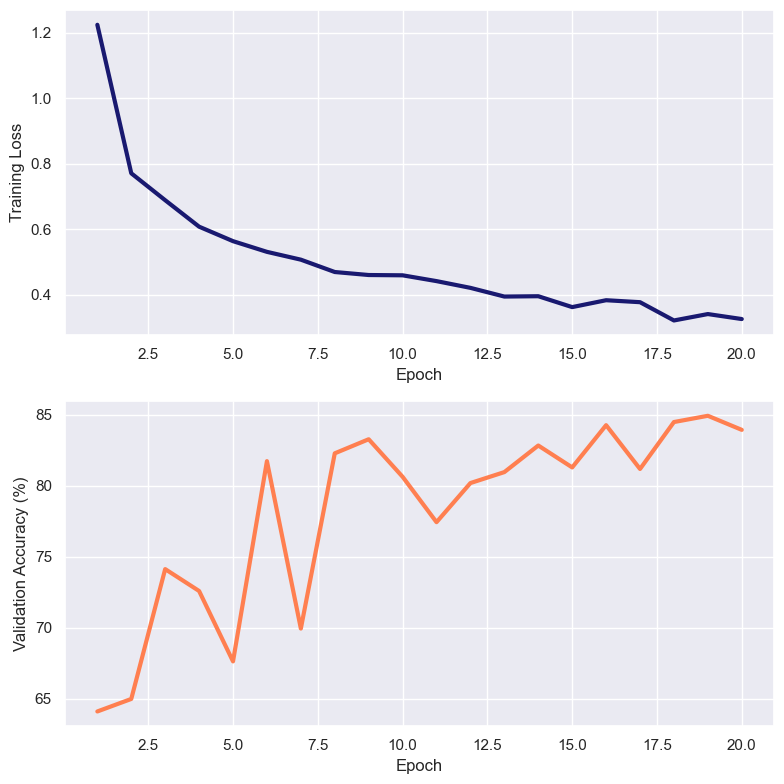

In [354]:
# plot training loss and validation accuracy
epochs = range(1, len(training_loss)+1)
loss = training_loss
accuracy = validation_accuracy

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
sns.set_theme(style='darkgrid')

sns.lineplot(x=epochs, y=loss, linewidth=3, dashes=False, color='midnightblue', ax=axs[0])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')

sns.lineplot(x=epochs, y=accuracy, linewidth=3, dashes=False, color='coral', ax=axs[1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation Accuracy (%)')

# adjust the layout to avoid overlapping
plt.tight_layout()

plt.grid(True)
plt.show()

In [ ]:
# save trained model
torch.save(pointnet.state_dict(), "pointnet_cls.pth")

In [40]:
# load trained model
pointnet = PointNet()
pointnet.load_state_dict(torch.load("pointnet_cls.pth"))
pointnet.eval()
pointnet = pointnet.cuda()

C:\Users\Jingxin.Zhang\AppData\Local\Temp\ipykernel_32728\4273132891.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [43]:
# test the model
correct = total = 0
all_preds = []
all_labels = []
test_accuracy = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs = data['pointcloud'].to(device).float()
        labels = data['category'].to(device)

        outputs, _, _ = pointnet(inputs.transpose(1, 2)) # outputs -> (batch_size, classes)
        _, predicts = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicts == labels).sum().item()

        # print statistics info every batch
        print('>>> Batch: %3d / %3d is done' % (i + 1, len(valid_loader)))

        all_preds += list(predicts.cpu().numpy())
        all_labels += list(labels.cpu().numpy())
    
    test_accuracy = 100. * correct / total
    print('>>> Test accuracy: %d%%' % test_accuracy)
    print('>>> ----------- Test is finished -----------')

>>> Batch:   1 /  15 is done
>>> Batch:   2 /  15 is done
>>> Batch:   3 /  15 is done
>>> Batch:   4 /  15 is done
>>> Batch:   5 /  15 is done
>>> Batch:   6 /  15 is done
>>> Batch:   7 /  15 is done
>>> Batch:   8 /  15 is done
>>> Batch:   9 /  15 is done
>>> Batch:  10 /  15 is done
>>> Batch:  11 /  15 is done
>>> Batch:  12 /  15 is done
>>> Batch:  13 /  15 is done
>>> Batch:  14 /  15 is done
>>> Batch:  15 /  15 is done
>>> Test accuracy: 84%
>>> ----------- Test is finished -----------


In [60]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print('>>> confusion matrix:')
print(cm)
print('>>> normalized confusion matrix:')
print(normalized_cm)

>>> confusion matrix:
[[41  9  0  0  0  0  0  0  0  0]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 0  0 99  0  0  0  0  1  0  0]
 [ 0  0  1 66  0  1  0  3 15  0]
 [ 0  1  0  3 38  2 40  0  2  0]
 [ 0  1  3  0  1 93  2  0  0  0]
 [ 0  5  1  0  4  0 58  1 16  1]
 [ 0  0  1  0  0  0  1 98  0  0]
 [ 0  0  0 13  0  0  0  0 87  0]
 [ 1  1  6  1  0  0  0  0  6 85]]
>>> normalized confusion matrix:
[[0.82       0.18       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99       0.01       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.99       0.         0.         0.
  0.         0.01       0.         0.        ]
 [0.         0.         0.01162791 0.76744186 0.         0.01162791
  0.         0.03488372 0.1744186  0.        ]
 [0.         0.01162791 0.         0.03488372 0.44186047 0.02325581
  0.46511628 0.         0.02325581 0.        ]
 [0.         0.01       0.03       0.         0.01       0.93
 

In [67]:
# confusion matrix visualization function
import itertools

def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # cm.sum(axis=1)[:, np.newaxis] -> total amount of each class in valid_loader
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    _format = '.2f' if normalize else 'd'
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], _format), horizontalalignment="center", color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


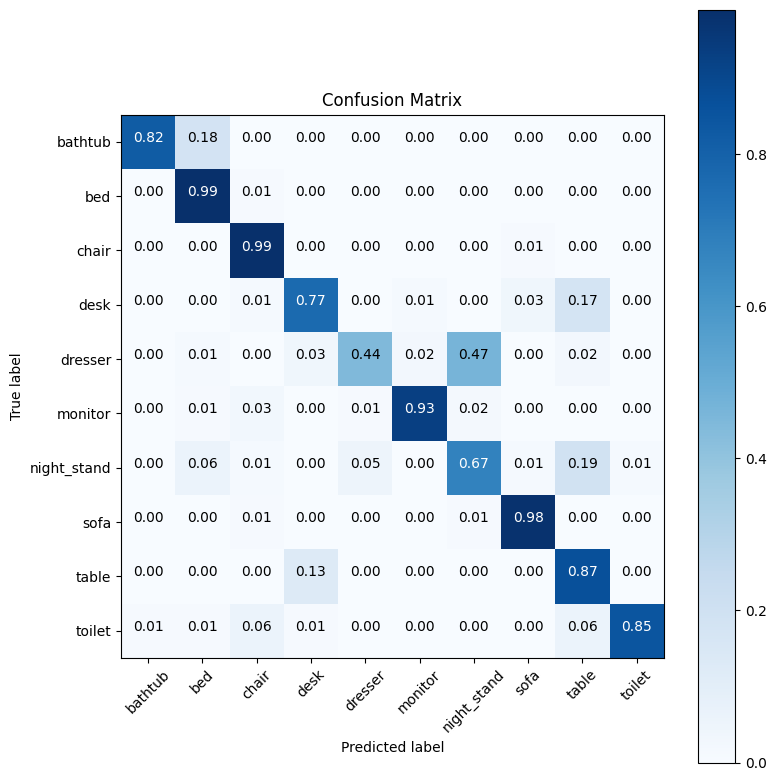

In [68]:
# plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix without normalization


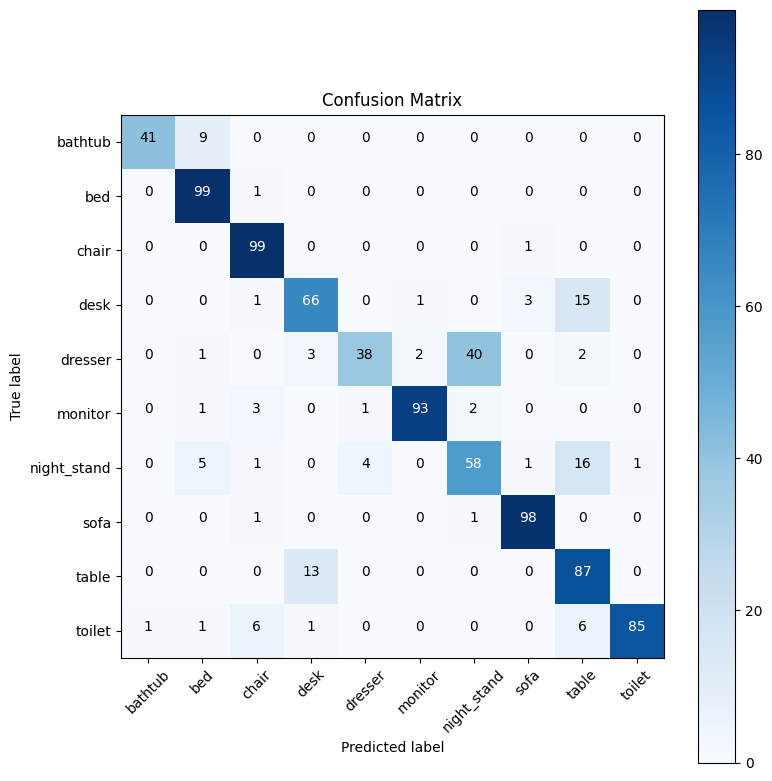

In [69]:
# plot confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)